In [1]:
import magnonRPA as rpa
import numpy as np

from matplotlib import pyplot as plt 
from matplotlib import colors as mclr
from matplotlib import colormaps as cmaps

import time

### Plotting settings 
#plt.rc('figure', dpi=100)
#plt.rc('figure',figsize=(4,1.7))
plt.rc('font', family = 'Times New Roman')
plt.rc('font', size = 14)
plt.rc('text', usetex=True)
plt.rc('xtick', labelsize=14)
plt.rc('ytick', labelsize=14)
plt.rc('axes', labelsize=18)
plt.rc('lines', linewidth=2.5)

saveFigs = False ### Option to save figures or not 

figDirectory = "../figures/" ### Figures are stored in this folder
dataDirectory = "../data/" ### Data is loaded from and stored to this folder


## Load in spectral function

In [2]:
### Location of hole spectral functions
holesDirectory = dataDirectory+"hole_spectra/05052025/" 
holesFile = "jon_request_0.5" 

### Load in spectral function
kxs,kys,ws,A = rpa.load_hole_spectrum(holesDirectory+holesFile)

### Useful to make vectorized grids and keep track of sizes of arrays
kxvs,kyvs,wvs = np.meshgrid(kxs,kys,ws)
Nkx = len(kxs)
Nky = len(kys)
Nw = len(ws)

## Plot hole spectrum

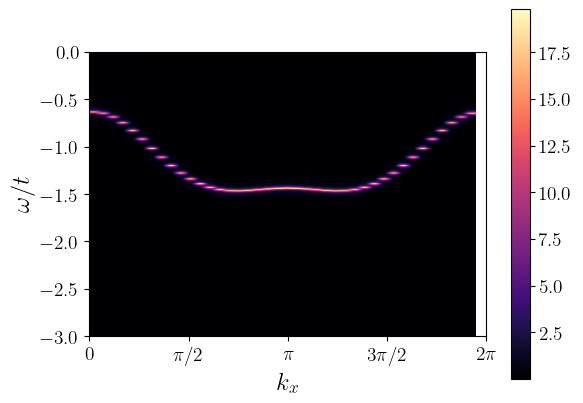

In [3]:
### Plot spectral function for a cut
plt.imshow(np.transpose(A[:,0,:]),extent=[kxs[0],kxs[-1],ws[0],ws[-1]],origin='lower',cmap='magma',aspect=1.5)
plt.colorbar()
plt.ylim(-3.*rpa.t,-0.*rpa.t)
plt.xlabel(r'$k_x$')
plt.ylabel(r'$\omega/t$')
plt.xticks([0,np.pi/2.,np.pi,3.*np.pi/2.,2.*np.pi],[r'0',r'$\pi/2$',r'$\pi$',r'$3\pi/2$',r'$2\pi$'])
plt.show()

## Set parameters and computing doping

In [4]:
T = 0.02*rpa.t ##$ temperature
U = 12.*rpa.t ### Hubbard U (used to compute J)
J = 4.*rpa.t**2/U ### Superexchange J
mu = -1.6*rpa.t ### Chemical potential (controls doping)


### Compute doping
delta = rpa.calc_density(kxs,kys,ws,A,mu,T)
print("Hole doping: {d:0.1%}".format(d=delta))
print("J/t used in LSWT: {jt:0.2f}".format(jt=J/rpa.t))

Hole doping: 3.2%
J/t used in LSWT: 0.33


## Now we compute the RPA kernel and magnon propagator

In [5]:
### Calculate RPA spectra from hole spectra 
t0 = time.time()
ImPi = rpa.calc_ImPi(kxs,kys,ws,A,mu,T)
t1 = time.time()
Pi = rpa.Kramers_Kronig(ws,ImPi)
t2 = time.time()
magnon_propagator = rpa.RPA_propagator(kxs,kys,ws,Pi,J)
t3 = time.time()
spectrum = rpa.RPA_spectrum(kxs,kys,ws,magnon_propagator)
t4 = time.time()

print("Time for RPA: ",t1-t0,"s")
print("Time for Kramers-Kronig: ",t2-t1,"s")
print("Time for inverting kernel: ",t3-t2,"s")
print("Time for computing spectrum: ",t4-t3,"s")

Time for RPA:  3.95711612701416 s
Time for Kramers-Kronig:  2.7703449726104736 s


In [6]:
### Magnon propagator
magnon_kernel = rpa.RPA_kernel(kxs,kys,ws,Pi,J)
magnon_propagator = np.zeros_like(magnon_kernel)
spectra = np.zeros((Nkx,Nky,Nw))

t0 = time.time()

magnon_propagator=rpa.RPA_propagator(kxs,kys,ws,Pi,J)
t1 = time.time()
spectra = rpa.RPA_spectrum(kxs,kys,ws,magnon_propagator)

#for i in range(len(kxs)):
#    for j in range(len(kys)):
#        for k in range(len(ws)):
#            magnon_propagator[:,:,i,j,k] = np.linalg.inv(magnon_kernel[:,:,i,j,k])
#            spectra[i,j,k] = ws[k]*np.imag( np.linalg.det(magnon_propagator[:,:,i,j,k]) )/np.pi

t2 = time.time()



Time for inverting kernel:  22.418476104736328 s
Time for computing spectrum:  0.6093981266021729 s


## Plotting and various diagonostics

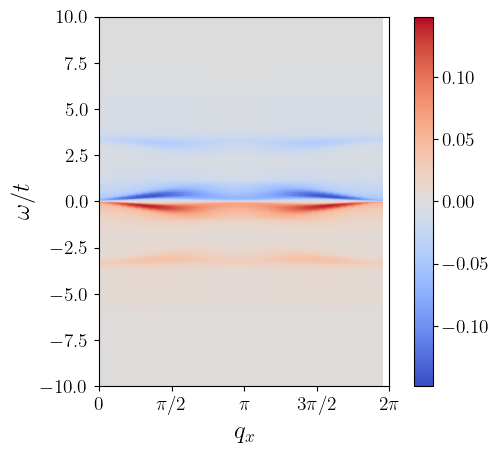

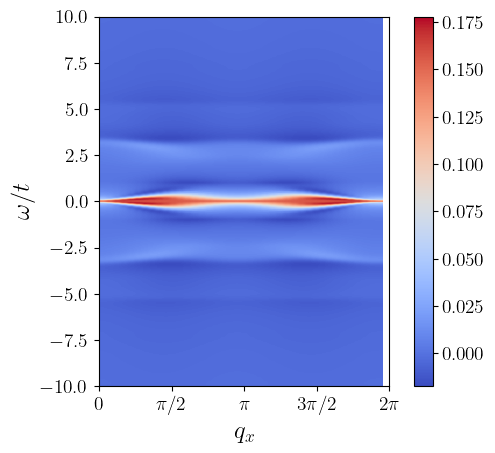

In [7]:
### Frequency dependence of Pi for kx cut 
plt.imshow(np.transpose(ImPi[:,0,:]),origin='lower',extent=[kxs[0],kxs[-1],ws[0],ws[-1]],aspect=0.4,cmap='coolwarm')
plt.xlabel(r'$q_x$')
plt.xticks([0,np.pi/2.,np.pi,3.*np.pi/2.,2.*np.pi],[r'0',r'$\pi/2$',r'$\pi$',r'$3\pi/2$',r'$2\pi$'])
plt.ylabel(r'$\omega/t$')
plt.colorbar()
if saveFigs: plt.savefig(figDirectory+"/ImPi_w_qx.pdf",bbox_inches='tight')
plt.show()

plt.imshow(np.transpose(np.real(Pi[:,0,:])),origin='lower',extent=[kxs[0],kxs[-1],ws[0],ws[-1]],aspect=0.4,cmap='coolwarm')
plt.xlabel(r'$q_x$')
plt.xticks([0,np.pi/2.,np.pi,3.*np.pi/2.,2.*np.pi],[r'0',r'$\pi/2$',r'$\pi$',r'$3\pi/2$',r'$2\pi$'])
plt.ylabel(r'$\omega/t$')
plt.colorbar()
if saveFigs: plt.savefig(figDirectory+"/RePi_w_qx.pdf",bbox_inches='tight')
plt.show()

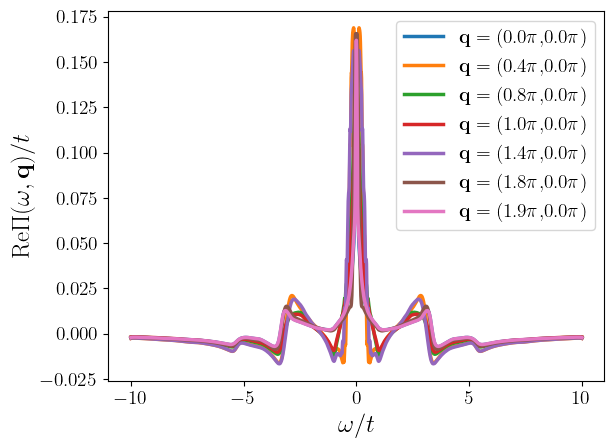

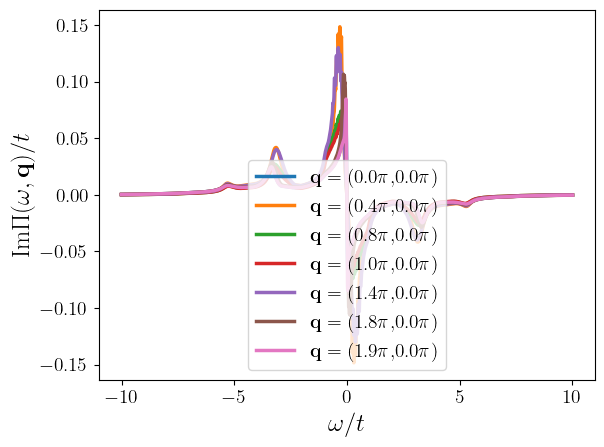

In [8]:
### Frequency-momentum cuts of RPA function
indices = [ [0,0],[8,0],[16,0],[20,0],[28,0],[36,0],[-1,0]]
#clrs = cmaps['Reds'](np.linspace(0.4,1.,len(indices)))
#clrs = ['red','green','blue','purple']
label_strings = [ r'$\mathbf{q}=($'+"{qx:0.1f}".format(qx=kxs[i[0]]/np.pi) + r'$\pi,$' + "{qy:0.1f}".format(qy=kys[i[1]]/np.pi) + r'$\pi)$'  for i in indices]

### Frequency cuts of polarizations of magnons
if True:
    for j in range(len(indices)):
        i = indices[j]
        plt.plot(ws/rpa.t,np.real(Pi[i[0],i[1],:])/rpa.t,label=label_strings[j])
    
    plt.xlabel(r'$\omega/t$')
    plt.ylabel(r'Re$\Pi(\omega,\mathbf{q})/t$')
    plt.legend()
    if saveFigs: plt.savefig(figDirectory+"/RePi.pdf",bbox_inches='tight')
    plt.show()

if True:
    for j in range(len(indices)):
        i = indices[j]
        plt.plot(ws/rpa.t,np.imag(Pi[i[0],i[1],:])/rpa.t,label=label_strings[j])

    plt.xlabel(r'$\omega/t$')
    plt.ylabel(r'Im$\Pi(\omega,\mathbf{q})/t$')
    plt.legend()
    if saveFigs: plt.savefig(figDirectory+"/ImPi.pdf",bbox_inches='tight')
    plt.show()


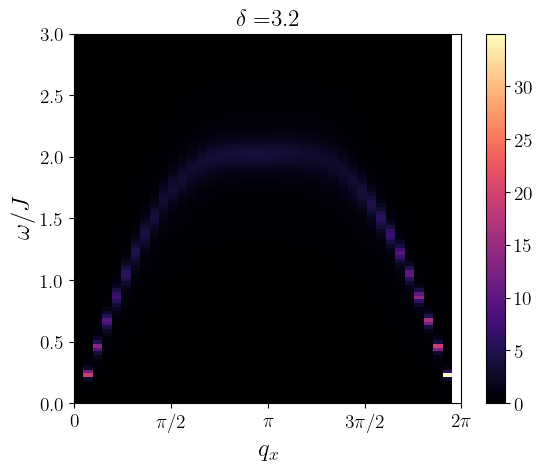

In [9]:
plt.imshow(np.transpose(spectra[:,0,:]),origin='lower',extent=[kxs[0],kxs[-1],ws[0]/J,ws[-1]/J],cmap='magma',aspect=2)
plt.ylabel(r'$\omega/J$')
plt.ylim(0,3.)
plt.xlabel(r'$q_x$')
plt.xticks([0,np.pi/2.,np.pi,3.*np.pi/2.,2.*np.pi],[r'0',r'$\pi/2$',r'$\pi$',r'$3\pi/2$',r'$2\pi$'])
plt.colorbar()
plt.title(r'$\delta = $'+"{:0.1%}".format(delta))
if saveFigs: plt.savefig(figDirectory+"/Magnon_spectrum.pdf",bbox_inches='tight')
plt.show()

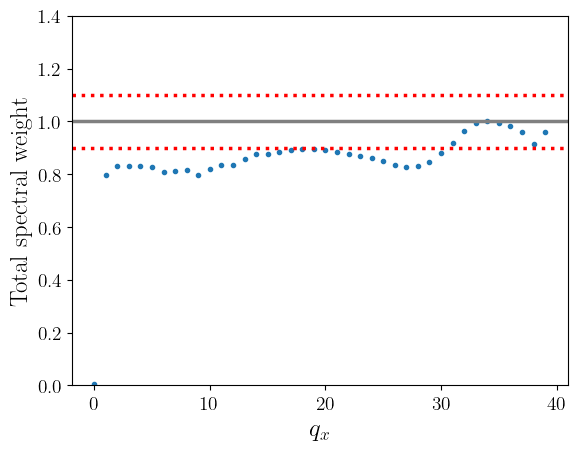

In [10]:
plt.plot(np.sum(spectra[:,0,:],axis=-1)*(ws[1]-ws[0]),'.')
plt.axhline(1.,linestyle='solid',color='gray')
plt.axhline(0.9,linestyle='dotted',color='red')
plt.axhline(1.1,linestyle='dotted',color='red')
plt.ylim(0.,1.4)
plt.xlabel(r'$q_x$')
plt.ylabel(r'Total spectral weight')
plt.show()